In [121]:
import os
import cmath
import numpy as np
import matplotlib.pyplot as plt

In [229]:
# perform fourier transform of the signal and recreate it perfectly, for sanity checking

class Fourier:

    def __init__(self, time_steps, signal):
        '''
        Constructs a Fourier object from a 1D-signal.

        :param time_steps: x-values at which the signal is sampled
        :param signal: y-values of the signal
        '''

        self.time_steps = time_steps
        self.signal = signal

        n = signal.size
        sampling_rate = n / (time_steps[-1] - time_steps[0])
        # sampling rate = how many times we measure the signal for every 1 step of distance
        #print("Created Fourier object with sampling rate: ", sampling_rate)  
        
        # run Fourier transform
        # contains complex numbers encoding the amplitudes and phase offsets of each constituent signal
        amp_phase = np.fft.fft(signal) 
        
        # obtain frequencies
        freqs = np.fft.fftfreq(n, d=1/sampling_rate)

        self.amp_phase = amp_phase
        self.freqs = freqs
        self.filtered = dict()  # will map frequencies to their amplitude-phase-pairs

        # create list containing amplitude-frequency pairs, ignoring the zero-frequency 
        pairs = []
        self.zero_comp = amp_phase[0], freqs[0]
        #print("zero-comp:", np.round(self.zero_comp[0]))
        for ap, frequency in zip(amp_phase[1:], freqs[1:]):
            pairs.append([ap, frequency]) # amplitude-phase is complex, frequency is real

        # sort the pairs descending by amplitude
        pairs = list(reversed(sorted(pairs, key=lambda v: abs(v[0]))))
        self.pairs = np.array(pairs)


    def filter(self, num):
        """
        Retains only the num largest amplitudes.

        :param num: number of amplitudes to keep
        """

        # by default, set all frequencies to 0
        for freq in self.freqs:
            self.filtered[freq] = 0.0

        # set the amplitude of the zero-frequency
        self.filtered[self.zero_comp[1]] = self.zero_comp[0]

        # set the amplitude-phase of the biggest num frequencies
        for ap, freq in self.pairs[:num]:
            self.filtered[freq] = ap
            

    def inverse(self):
        '''
        Calculate inverse fourier transform from filtered frequencies.
        '''

        wave = []
        for f in self.freqs:
            wave.append(self.filtered[f])
        wave = np.array(wave)

        res = np.fft.ifft(wave)

        return res
    
    
    def obtain_constituent_waves(self):
        '''
        Returns the constituent waves that make up the original signal, after filtering. 
        A wave is characterized by its frequency, amplitude and phase shift.
        So this method returns all constituent waves with non-zero amplitude, sorted by descending amplitude, as
        a list of (frequency, amplitude, phase-shift)-tuples, were phase-shift is in radians (-pi to pi).
        '''
        waves = []
        for freq, ap in self.filtered.items():
            if freq != 0.0 and ap != 0.0:
                waves.append((freq, abs(ap)/self.signal.size, cmath.phase(ap)))

        offset = abs(self.filtered[0.0]) / self.signal.size
        ordered =  list(reversed(sorted(waves, key=lambda v: v[1])))
        
        return offset, ordered


def vis_signal(time_steps, signal, title):
    '''
    Visualizes a signal by plotting it.

    :param time_steps: the x-values of the signal
    :param signal: the y-values of the signal
    :param title: the title of the plot
    '''

    # plotting signal in time domain
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, signal)
    plt.xlim(time_steps[0], time_steps[-1])
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.title(title)
    plt.show()


def design_matrix(xvals, offset, waves):
    '''
    Creates a design matrix of dimension (num_timesteps x num_features), with one feature per constituent wave 
    plus one feature for the offset (which is probably irrelevant but meh).
    The idea is that the consituent waves are evaluated at each point in xval.
    '''
    
    matr = np.zeros((len(xvals), len(waves)+1))
    
    for i, wave in enumerate(waves):
        freq = wave[0]
        amp = wave[1]
        phase = wave[2]
        matr[:,i] = np.array([amp * np.cos(2*np.pi*freq*x + phase) for x in xvals])
        
    matr[:,-1] = offset
    
    return matr


def main(xvals, yvals, num_freq):
    '''
    Generates a noisy signal by adding some zero-centered gaussian noise 
    to a base signal constructed from adding clean sine and cosine waves.

    Visualizes the original signal.
    
    Performs fourier transform and filters the frequencies to apply
    low-pass filtering which should remove the noise.

    Visualizes the cleaned signal.
    
    xvals = sampling points on x-axis
    yvals = values of the signal at sampling points
    num_freq = number of frequencies to keep
    '''
    
    signal = np.array(yvals, dtype=float)

    vis_signal(xvals, signal, 'Original Signal in Time Domain')

    fou = Fourier(xvals, signal)

    fou.filter(num_freq)

    clean_signal = fou.inverse()
    
    offset, waves = fou.obtain_constituent_waves()
    print("Found offset:", offset)
    plt.figure(figsize=(10,5))
    plt.plot(xvals, [offset]*len(xvals), label = "offset")
    for i, w in enumerate(waves):
        fr = np.round(w[0], 2)
        amp = np.round(w[1],2)
        ph = np.round(w[2],3)
        ph_deg = np.round(w[2]/np.pi*180, 2)
        
        plt.plot(xvals, [amp * np.cos(2*np.pi*fr*x + ph)+ i/10 for x in xvals], label=i)

        #print(f"{i}: Found wave with frequency {fr}, amplitude {amp} and phase-shift {ph} (= {ph_deg}°)")
    
    plt.legend()
    plt.show()

    vis_signal(xvals, clean_signal.real, 'Reproduced Signal in Time Domain')
    
    mse = sum((signal.real - clean_signal.real)**2)
    print("Signal was reproduced with MSE of: ", mse)
    
    print("\nDesign Matrix:")
    matrix = design_matrix(np.array([np.pi/2*i for i in range(8)]), offset, waves)
    print(matrix)

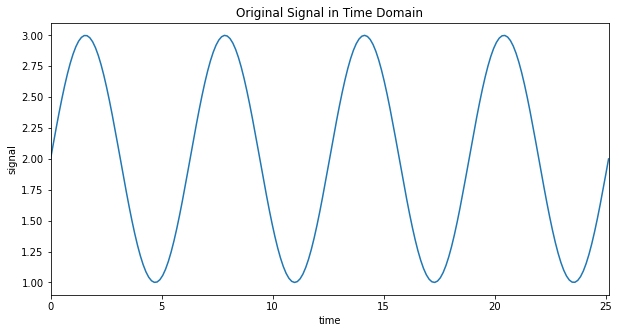

Found offset: 2.0


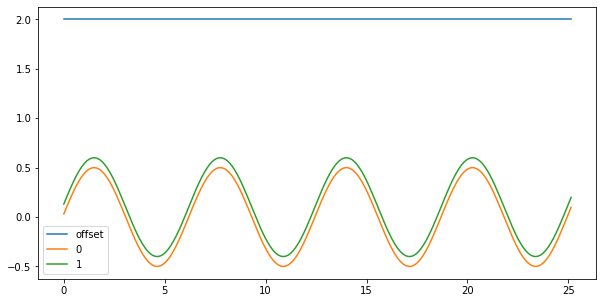

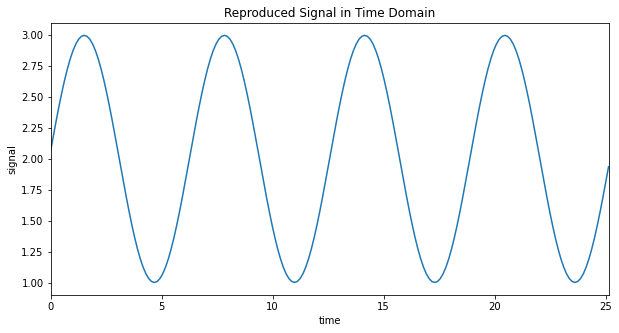

Signal was reproduced with MSE of:  0.13412981103130056

Design Matrix:
[[ 0.03129556  0.03129556  2.        ]
 [ 0.49742865  0.49742865  2.        ]
 [-0.03129556 -0.03129556  2.        ]
 [-0.49742865 -0.49742865  2.        ]
 [ 0.03129556  0.03129556  2.        ]
 [ 0.49742865  0.49742865  2.        ]
 [-0.03129556 -0.03129556  2.        ]
 [-0.49742865 -0.49742865  2.        ]]


In [230]:
# most basic example: sine wave
def signal(x):
    return np.sin(x) + 2

start = 0
stop = 8*np.pi
num = 200

xvals = np.linspace(start, stop, num)
yvals = signal(xvals)

main(xvals, yvals, 2)

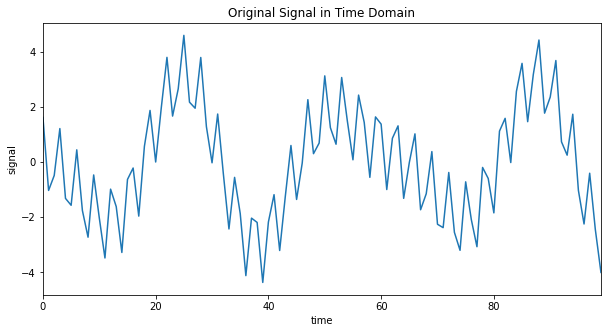

Found offset: 0.021339106994345443


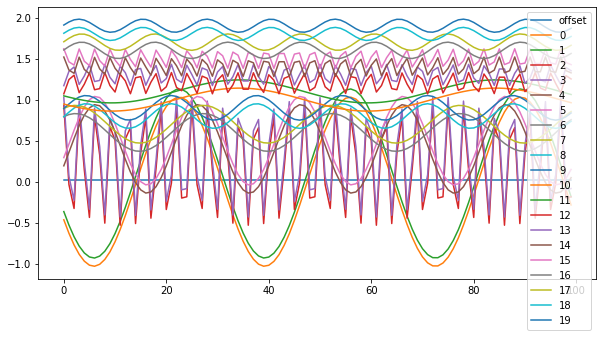

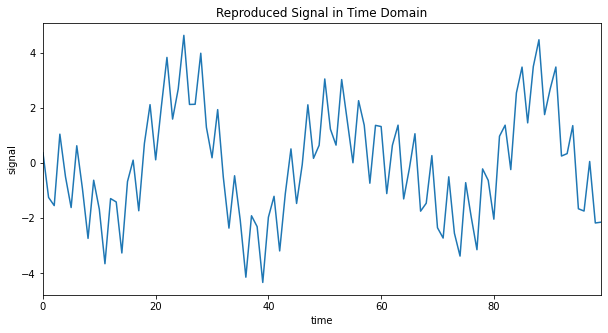

Signal was reproduced with MSE of:  10.857805232360116

Design Matrix:
[[-0.46509132 -0.46509132  0.72990923  0.72990923 -0.20529566 -0.20529566
   0.19456387  0.19456387 -0.00861222 -0.00861222 -0.05382874 -0.05382874
  -0.12646573 -0.12646573  0.12133664  0.12133664  0.00492711  0.00492711
   0.00845685  0.00845685  0.02133911]
 [-0.71590807 -0.71590807 -0.7330652  -0.7330652   0.05720279  0.05720279
   0.22844198  0.22844198  0.07924422  0.07924422 -0.07796761 -0.07796761
   0.12609811  0.12609811 -0.12293656 -0.12293656  0.07062842  0.07062842
   0.06380091  0.06380091  0.02133911]
 [-0.90316405 -0.90316405  0.73449128  0.73449128  0.30578008  0.30578008
   0.22647232  0.22647232  0.13958301  0.13958301 -0.09901716 -0.09901716
  -0.12540116 -0.12540116  0.12183859  0.12183859  0.10330741  0.10330741
   0.08066876  0.08066876  0.02133911]
 [-1.01023401 -1.01023401 -0.73418411 -0.73418411  0.47994121  0.47994121
   0.18896396  0.18896396  0.15145143  0.15145143 -0.11614332 -0.1161433

In [231]:
# create signal: sum of phase-shifted sine and cosine signals with different amplitudes 
def signal(x):
    return 1.5 * np.sin(2+2*x) + 2.2 * np.cos(1.5+0.2*x) + np.sin(0.1+0.3*x)

xvals = np.arange(0,100)
yvals = signal(xvals)

main(xvals, yvals, 20)